In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy.inspection import inspect

In [5]:
# create engine for db
engine = create_engine("sqlite:///hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)
for c in inspector.get_columns('measurement'):
    print(c['name'])

id
station
date
prcp
tobs


In [11]:
inspector = inspect(engine)
for c in inspector.get_columns('station'):
    print(c['name'])

id
station
name
latitude
longitude
elevation


# Exploratory Climate Analysis

(array([-500.,    0.,  500., 1000., 1500., 2000., 2500.]),
 [Text(-500.0, 0, '2017-05-27'),
  Text(0.0, 0, '2016-08-23'),
  Text(500.0, 0, '2016-11-09'),
  Text(1000.0, 0, '2017-01-28'),
  Text(1500.0, 0, '2017-04-18'),
  Text(2000.0, 0, '2017-07-10'),
  Text(2500.0, 0, '')])

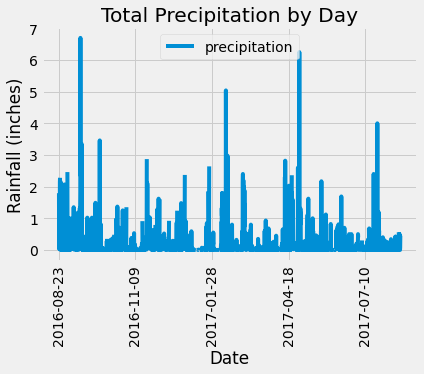

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
#Starting from the last data point in the database. 
prev_year = dt.date(2017,8,23)

# Calculate the date one year from the last date in data set.
prev_year = dt.date(2017,8,23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = list() #variable to store query
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= prev_year)

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns=['date','precipitation'])
df.set_index(df['date'], inplace=True)

# Sort the dataframe by date
df = df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
df.plot()
plt.ylabel("Rainfall (inches)")
plt.xlabel("Date")
plt.title("Total Precipitation by Day")
plt.xticks(rotation=90)

In [13]:
# print results
# print(results)
# print(results.all())

In [14]:
df.head()

,date,precipitation
date,,
2016-08-23,2016-08-23,0.00
2016-08-23,2016-08-23,NaN
2016-08-23,2016-08-23,1.79
2016-08-23,2016-08-23,0.05
2016-08-23,2016-08-23,0.15


In [15]:
print(df.to_string(index=False))

      date  precipitation
2016-08-23           0.00
2016-08-23            NaN
2016-08-23           1.79
2016-08-23           0.05
2016-08-23           0.15
2016-08-23           0.70
2016-08-23           0.02
2016-08-24           0.08
2016-08-24           2.15
2016-08-24           2.28
2016-08-24            NaN
2016-08-24           1.45
2016-08-24           1.22
2016-08-24           2.15
2016-08-25           0.08
2016-08-25           0.00
2016-08-25           0.21
2016-08-25           0.06
2016-08-25           0.00
2016-08-25           0.11
2016-08-25           0.08
2016-08-26           0.03
2016-08-26           0.01
2016-08-26           0.00
2016-08-26           0.04
2016-08-26           0.02
2016-08-26           0.00
2016-08-27           0.18
2016-08-27           0.12
2016-08-27           0.00
2016-08-27           0.00
2016-08-27           0.02
2016-08-27            NaN
2016-08-28           0.60
2016-08-28           0.14
2016-08-28           0.01
2016-08-28           0.14
2016-08-28  

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [17]:
# How many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9,)]

In [18]:
# What are the most active stations?
# Stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

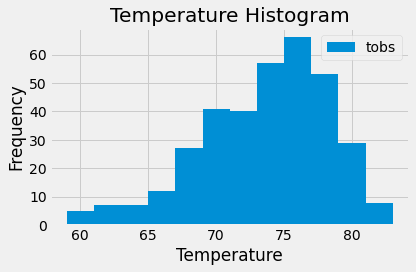

In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results = session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= prev_year).all()
# print(results)

#create pd DF from results
df = pd.DataFrame(results, columns=['tobs'])

#histogram
df.plot.hist(bins=12)
plt.xlabel("Temperature")
plt.title("Temperature Histogram")
plt.tight_layout()

In [21]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    calc_temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
        filter(Measurement.date >= start_date).\
        filter(Measurement.date <= end_date)
    return calc_temps.all()

In [22]:
calc_temps('2017-01-01', '2017-03-31')

[(74.0, 80.0, 77.57142857142857)]

# Challenge